# ours 먼저 돌리기

In [ ]:
import json
import os
import time
import win32com.client
import pythoncom
import jsonlines
from pathlib import Path
from main_original import main  # main 함수 import

def load_instructions(json_path):
    """instruction JSON 파일을 로드합니다."""
    try:
        with open(json_path, 'r', encoding='utf-8') as f:
            return json.load(f)
    except Exception as e:
        print(f"JSON 파일 로드 오류: {e}")
        return {}

def get_slide_number(instruction_key):
    """instruction key에서 슬라이드 번호를 추출합니다."""
    if '-' in instruction_key:
        return instruction_key.split('-')[0]
    return instruction_key

def write_log(log_file, log_data):
    """로그 파일에 안전하게 데이터를 기록합니다."""
    max_retries = 3
    for attempt in range(max_retries):
        try:
            with jsonlines.open(log_file, mode='a') as writer:
                writer.write(log_data)
            return True
        except Exception as e:
            if attempt < max_retries - 1:
                print(f"로그 작성 오류, 재시도 중 ({attempt+1}/{max_retries}): {e}")
                time.sleep(0.5)
            else:
                print(f"로그 작성 최종 실패: {e}")
                return False

def process_instruction(instruction_key, instruction_text, result_folder, log_file):
    """
    주어진 instruction을 처리하고 결과를 저장합니다.
    1. PPT 열고 main() 적용
    2. SaveAs, 실패 시 SaveCopyAs → 원위치 이동
    3. 프레젠테이션 즉시 Close
    4. PowerPoint 애플리케이션 Quit
    5. 로그 기록
    """
    slide_num = get_slide_number(instruction_key)
    slide_path = os.path.abspath(f"evaluation/benchmark_ppts/slide_{slide_num}.pptx")
    result_path = os.path.join(result_folder, f"result_slide_{slide_num}_instruction_{instruction_key}.pptx")

    pythoncom.CoInitialize()
    ppt_app = None
    presentation = None
    start_time = time.time()
    status = "error"
    error_message = None
    result = None

    try:
        # PowerPoint 연결 또는 실행
        try:
            ppt_app = win32com.client.GetActiveObject("PowerPoint.Application")
        except:
            ppt_app = win32com.client.Dispatch("PowerPoint.Application")
        if ppt_app is None:
            raise RuntimeError("PowerPoint 애플리케이션을 시작할 수 없습니다.")

        ppt_app.Visible = True
        
        # 프레젠테이션을 확실히 열고 준비되었는지 확인
        presentation = ppt_app.Presentations.Open(slide_path)
        if presentation is None:
            raise RuntimeError(f"프레젠테이션을 열 수 없습니다: {slide_path}")
        
        # PowerPoint가 완전히 로드될 시간을 제공
        time.sleep(0.5)
        
        # 인스트럭션 포맷팅
        if "{slide_num}" in instruction_text:
            formatted_instruction = instruction_text.replace("{slide_num}", "1")
        else:
            formatted_instruction = instruction_text
        
        # main 함수 실행 - PowerPoint가 확실히 준비된 후에 실행
        try:
            # 먼저 presentation이 active한지 확인
            ppt_app.ActivePresentation  # 이 호출로 PowerPoint가 활성화되어 있는지 확인
            result = main(formatted_instruction, rule_base_apply=False)
        except Exception as main_err:
            error_message = f"main() 함수 실행 오류: {main_err}"
            raise RuntimeError(error_message)

        # 디렉토리 및 파일 준비
        os.makedirs(os.path.dirname(result_path), exist_ok=True)
        if os.path.exists(result_path):
            try:
                os.remove(result_path)
            except:
                # 잠금 문제 시 이름 변경
                result_path = os.path.join(
                    result_folder,
                    f"result_slide_{slide_num}_instruction_{instruction_key}_{int(time.time())}.pptx"
                )

        absolute_result_path = os.path.abspath(result_path)
        save_success = False

        # 1차: SaveAs
        try:
            presentation.SaveAs(FileName=absolute_result_path)
            save_success = True
        except Exception as save_err:
            # 2차: SaveCopyAs + 이동
            try:
                temp_name = f"temp_{int(time.time())}_{os.path.basename(result_path)}"
                temp_path = os.path.join(os.path.dirname(absolute_result_path), temp_name)
                presentation.SaveCopyAs(FileName=temp_path)
                # 바로 프레젠테이션 닫기
                presentation.Close()
                presentation = None
                time.sleep(0.5)
                if os.path.exists(temp_path):
                    if os.path.exists(absolute_result_path):
                        os.remove(absolute_result_path)
                    os.rename(temp_path, absolute_result_path)
                    save_success = True
            except Exception as alt_err:
                error_message = f"SaveAs 실패: {save_err}; SaveCopyAs 실패: {alt_err}"

        # 저장 후 즉시 닫기
        if save_success:
            status = "success"
            # presentation이 남아있다면 닫기
            if presentation:
                presentation.Close()
                presentation = None

    except Exception as e:
        error_message = str(e)
        print(f"오류 발생: {instruction_key} – {e}")

    finally:
        # 애플리케이션 종료
        try:
            if ppt_app:
                ppt_app.Quit()
        except Exception as quit_err:
            print(f"PowerPoint Quit 오류: {quit_err}")

        # 로그 기록
        end_time = time.time()
        log_data = {
            "instruction_key": instruction_key,
            "slide_num": slide_num,
            "instruction": instruction_text #.replace("{slide_num}", str(int(slide_num) + 1))
            ,
            "execution_time": end_time - start_time,
            "status": status
        }
        if status == "success":
            log_data["result"] = result
        if error_message:
            log_data["error_message"] = error_message
        write_log(log_file, log_data)

        try:
            pythoncom.CoUninitialize()
        except:
            pass

def main_experiment():
    total_start = time.time()
    instruction_path = "expanded_instruction_379.json"
    result_folder = "result_gpt4-1"
    log_file = os.path.join(result_folder, "experiment_log.jsonl")
    os.makedirs(result_folder, exist_ok=True)

    # 기존 로그 파일에서 이미 처리된 instruction_key 로드
    processed_keys = set()
    if os.path.exists(log_file):
        try:
            with jsonlines.open(log_file, mode='r') as reader:
                for log_entry in reader:
                    # instruction_key가 있는 항목만 추가 (요약 항목 제외)
                    if 'instruction_key' in log_entry:
                        processed_keys.add(log_entry['instruction_key'])
            print(f"로그 파일에서 {len(processed_keys)}개의 이미 처리된 instruction을 발견했습니다.")
        except Exception as e:
            print(f"기존 로그 파일 읽기 오류: {e}")
            # 오류 발생 시 빈 세트로 계속 진행
            pass

    instructions = load_instructions(instruction_path)
    if not instructions:
        print("인스트럭션 로드 실패, 종료합니다.")
        return

    processed = 0
    skipped = 0
    for key, text in instructions.items():
        # 이미 처리된 instruction 건너뛰기
        if key in processed_keys:
            print(f"이미 처리된 instruction 건너뛰기: {key}")
            skipped += 1
            continue
            
        if "{{slide_number}}" in text:
            text = text.replace("{{slide_number}}", "1")
        process_instruction(key, text, result_folder, log_file)
        processed += 1
        time.sleep(1)

    total_end = time.time()
    summary = {
        "total_processed": processed,
        "total_skipped": skipped,
        "total_time": total_end - total_start,
        "avg_time": (total_end - total_start) / processed if processed else 0,
        "timestamp": time.strftime("%Y-%m-%d %H:%M:%S")
    }
    write_log(log_file, summary)
    print("실험 완료:", summary)

if __name__ == "__main__":
    main_experiment()

c:\Users\wjdrb\anaconda3\envs\pptagent\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


로그 파일에서 71개의 이미 처리된 instruction을 발견했습니다.
이미 처리된 instruction 건너뛰기: 0
이미 처리된 instruction 건너뛰기: 1
이미 처리된 instruction 건너뛰기: 2
이미 처리된 instruction 건너뛰기: 3
이미 처리된 instruction 건너뛰기: 4
이미 처리된 instruction 건너뛰기: 5
이미 처리된 instruction 건너뛰기: 6
이미 처리된 instruction 건너뛰기: 7
이미 처리된 instruction 건너뛰기: 8
이미 처리된 instruction 건너뛰기: 9
이미 처리된 instruction 건너뛰기: 10
이미 처리된 instruction 건너뛰기: 11
이미 처리된 instruction 건너뛰기: 12
이미 처리된 instruction 건너뛰기: 13
이미 처리된 instruction 건너뛰기: 14
이미 처리된 instruction 건너뛰기: 15
이미 처리된 instruction 건너뛰기: 16
이미 처리된 instruction 건너뛰기: 17
이미 처리된 instruction 건너뛰기: 18
이미 처리된 instruction 건너뛰기: 19
이미 처리된 instruction 건너뛰기: 20
이미 처리된 instruction 건너뛰기: 21
이미 처리된 instruction 건너뛰기: 22
이미 처리된 instruction 건너뛰기: 23
이미 처리된 instruction 건너뛰기: 24
이미 처리된 instruction 건너뛰기: 25
이미 처리된 instruction 건너뛰기: 26
이미 처리된 instruction 건너뛰기: 27
이미 처리된 instruction 건너뛰기: 28
이미 처리된 instruction 건너뛰기: 29
이미 처리된 instruction 건너뛰기: 30
이미 처리된 instruction 건너뛰기: 31
이미 처리된 instruction 건너뛰기: 32
이미 처리된 instruction 건너뛰기: 33
이미 처리된 instructio

2025-05-14 01:32:56.871 | DEBUG    | gemini_api:send_gemini_request:93 - API key: ***********************************M5D0
2025-05-14 01:33:42.470 | DEBUG    | gemini_api:send_gemini_request:93 - API key: ***********************************M5D0
2025-05-14 01:34:26.331 | DEBUG    | gemini_api:send_gemini_request:93 - API key: ***********************************M5D0
2025-05-14 01:35:10.062 | DEBUG    | gemini_api:send_gemini_request:93 - API key: ***********************************M5D0
2025-05-14 01:35:56.925 | DEBUG    | gemini_api:send_gemini_request:93 - API key: ***********************************M5D0
2025-05-14 01:36:33.739 | DEBUG    | gemini_api:send_gemini_request:93 - API key: ***********************************M5D0
2025-05-14 01:37:12.422 | DEBUG    | gemini_api:send_gemini_request:93 - API key: ***********************************M5D0
2025-05-14 01:38:15.173 | DEBUG    | gemini_api:send_gemini_request:93 - API key: ***********************************M5D0
2025-05-14 01:39:58.288 

In [1]:
# 셀 1: 라이브러리 임포트
import json
import pandas as pd
import numpy as np
from IPython.display import display


In [2]:
# 셀 2: JSONL 파일 로드 함수 정의 및 데이터 프레임 생성
def load_jsonl(filepath):
    """JSONL 파일을 읽어 pandas.DataFrame 으로 반환"""
    records = []
    with open(filepath, 'r', encoding='utf-8') as f:
        for line in f:
            obj = json.loads(line)
            if 'instruction_key' in obj:
                records.append(obj)
    return pd.DataFrame(records)

# 실제 로드
df = load_jsonl("result_gpt4-1/experiment_log.jsonl")
df.head()


,instruction_key,slide_num,instruction,execution_time,status,result,error_message
0,0,0,Translate all visible text elements on ppt sli...,26.723944,success,"[False, 2547, 878, 0.0020043500000000002]",NaN
1,1,1,Translate all visible text elements on ppt sli...,31.418732,success,"[True, 4851, 1750, 0.00427045]",NaN
2,2,2,Simplify the main body text on ppt slide numbe...,31.334344,success,"[True, 3836, 1665, 0.0037222750000000006]",NaN
3,3,3,Condense the speaker notes attached to ppt sli...,32.124140,success,"[True, 4220, 1953, 0.004270375]",NaN
4,4,4,Replace the original body text on slide number...,34.305507,success,"[True, 4061, 1486, 0.0035099500000000004]",NaN


In [3]:
# 셀 3: 'result' 컬럼 분해 및 성공 플래그 생성
df['success_flag'] = df['status'] == 'success'

# 안전하게 result 리스트에서 토큰·비용 분리
df['input_tokens'] = df['result'].apply(
    lambda r: r[1] if isinstance(r, list) and len(r) > 1 else np.nan
)
df['output_tokens'] = df['result'].apply(
    lambda r: r[2] if isinstance(r, list) and len(r) > 2 else np.nan
)
df['cost'] = df['result'].apply(
    lambda r: r[3] if isinstance(r, list) and len(r) > 3 else np.nan
)

display(df.loc[:, ['instruction_key','status','execution_time','input_tokens','output_tokens','cost']].head())


,instruction_key,status,execution_time,input_tokens,output_tokens,cost
0,0,success,26.723944,2547.0,878.0,0.002004
1,1,success,31.418732,4851.0,1750.0,0.004270
2,2,success,31.334344,3836.0,1665.0,0.003722
3,3,success,32.124140,4220.0,1953.0,0.004270
4,4,success,34.305507,4061.0,1486.0,0.003510


In [4]:
# 셀 4: 통계 계산 및 출력
# 1) 실행 성공율
success_rate = df['success_flag'].mean()

# 2) execution_time 통계
exec_mean = df['execution_time'].mean()
exec_var  = df['execution_time'].var()
exec_sum  = df['execution_time'].sum()

# 3) 토큰·비용 통계
stats = {}
for col in ['input_tokens','output_tokens','cost']:
    stats[col] = {
        'mean': df[col].mean(),
        'var' : df[col].var(),
        'sum' : df[col].sum()
    }

# 4) 전체 요약 통계
summary = df[['execution_time','input_tokens','output_tokens','cost']].describe()

# 5) 상태별 건수
counts_by_status = df['status'].value_counts()

# 결과 출력
print(f"✅ 실행 성공율: {success_rate*100:.2f}%\n")

print("⏱ execution_time")
print(f"  평균: {exec_mean:.3f}s, 분산: {exec_var:.3f}, 합계: {exec_sum:.3f}s\n")

for col, v in stats.items():
    print(f"📊 {col}")
    print(f"  평균: {v['mean']:.2f}, 분산: {v['var']:.2f}, 합계: {v['sum']:.2f}\n")

print("🔢 상태별 건수")
display(counts_by_status)

print("\n📝 전체 요약 통계")
display(summary)


✅ 실행 성공율: 96.57%

⏱ execution_time
  평균: 78.365s, 분산: 6092.210, 합계: 29700.392s

📊 input_tokens
  평균: 3680.54, 분산: 4724350.33, 합계: 1347079.00

📊 output_tokens
  평균: 1889.51, 분산: 1369383.69, 합계: 691561.00

📊 cost
  평균: 0.00, 분산: 0.00, 합계: 1.41

🔢 상태별 건수


status
success    366
error       13
Name: count, dtype: int64


📝 전체 요약 통계


,execution_time,input_tokens,output_tokens,cost
count,379.000000,366.000000,366.000000,366.000000
mean,78.365152,3680.543716,1889.510929,0.003839
std,78.052612,2173.557067,1170.206688,0.002791
min,3.393506,610.000000,159.000000,0.000094
25%,31.965200,2999.750000,1189.250000,0.002462
50%,49.642741,3645.500000,1738.500000,0.003650
75%,105.065194,4611.750000,2396.000000,0.005038
max,472.884686,12397.000000,8219.000000,0.017578


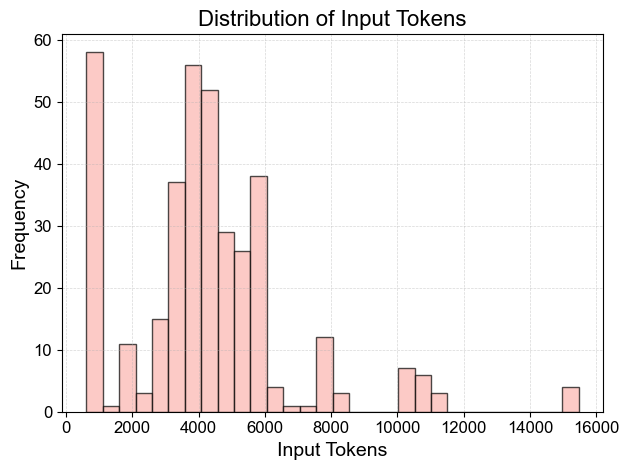

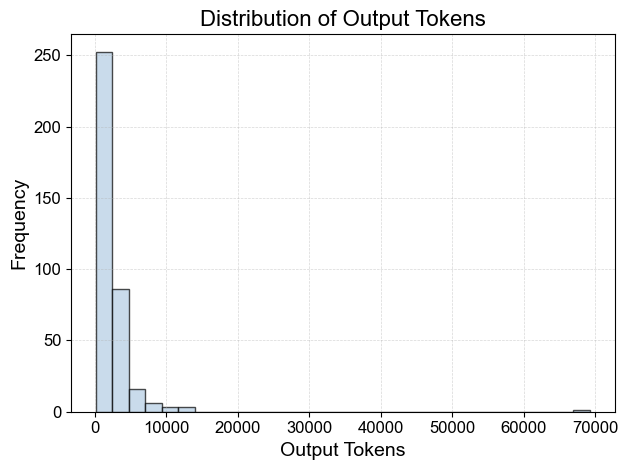

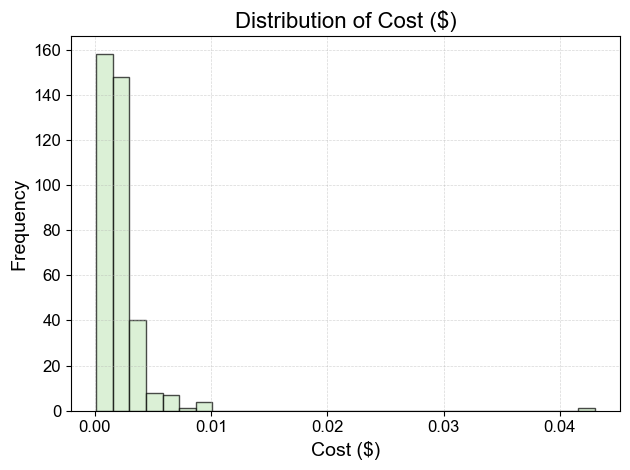

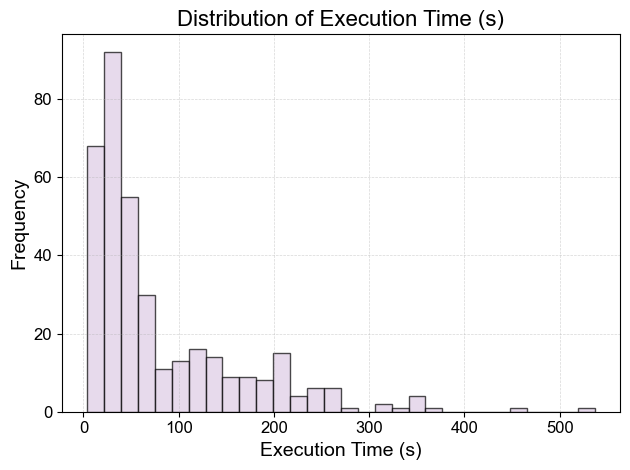

In [5]:
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.sans-serif'] = ['Helvetica', 'Arial']


# Load and preprocess data
records = []
with open('result/experiment_log.jsonl', 'r', encoding='utf-8') as f:
    for line in f:
        obj = json.loads(line)
        if 'instruction_key' in obj:
            records.append(obj)

df = pd.DataFrame(records)

# Extract result columns safely
df['input_tokens'] = df['result'].apply(lambda r: r[1] if isinstance(r, list) and len(r) > 1 else np.nan)
df['output_tokens'] = df['result'].apply(lambda r: r[2] if isinstance(r, list) and len(r) > 2 else np.nan)
df['cost'] = df['result'].apply(lambda r: r[3] if isinstance(r, list) and len(r) > 3 else np.nan)

# Filter only successful executions
df_success = df[df['status'] == 'success']

# Pastel color palette
colors = plt.get_cmap('Pastel1').colors

# Variables for histograms
variables = ['input_tokens', 'output_tokens', 'cost', 'execution_time']
titles = {
    'input_tokens': 'Input Tokens',
    'output_tokens': 'Output Tokens',
    'cost': 'Cost ($)',
    'execution_time': 'Execution Time (s)'
}

# Generate separate histograms for each variable
for i, var in enumerate(variables):
    plt.figure()
    data = df_success[var].dropna()
    plt.hist(data, bins=30, color=colors[i % len(colors)], edgecolor='black', alpha=0.7)
    plt.title(f'Distribution of {titles[var]}', fontsize=16)
    plt.xlabel(titles[var], fontsize=14)
    plt.ylabel('Frequency', fontsize=14)
    plt.tick_params(axis='both', labelsize=12)
    plt.grid(True, linestyle='--', linewidth=0.5, alpha=0.5)
    plt.tight_layout()
    plt.show()


📊 전체 데이터 통계
✅ 실행 성공율: 96.57%

⏱ execution_time
  평균: 78.365s, 분산: 6092.210, 합계: 29700.392s

📊 input_tokens
  평균: 3680.54, 분산: 4724350.33, 합계: 1347079.00

📊 output_tokens
  평균: 1889.51, 분산: 1369383.69, 합계: 691561.00

📊 cost
  평균: 0.00, 분산: 0.00, 합계: 1.41

🔢 상태별 건수


status
success    366
error       13
Name: count, dtype: int64


📝 전체 요약 통계


,execution_time,input_tokens,output_tokens,cost
count,379.000000,366.000000,366.000000,366.000000
mean,78.365152,3680.543716,1889.510929,0.003839
std,78.052612,2173.557067,1170.206688,0.002791
min,3.393506,610.000000,159.000000,0.000094
25%,31.965200,2999.750000,1189.250000,0.002462
50%,49.642741,3645.500000,1738.500000,0.003650
75%,105.065194,4611.750000,2396.000000,0.005038
max,472.884686,12397.000000,8219.000000,0.017578




📊 카테고리별 통계

🔢 카테고리별 데이터 건수


category
VisualFormatting            123
TextEditing                 116
LayoutAndImageAdjustment     95
SlideStructure               45
Name: count, dtype: int64


✅ 카테고리별 성공률


category
LayoutAndImageAdjustment    97.894737
SlideStructure              91.111111
TextEditing                 98.275862
VisualFormatting            95.934959
Name: success_flag, dtype: float64


📊 카테고리별 평균값


,execution_time,input_tokens,output_tokens,cost
category,,,,
LayoutAndImageAdjustment,89.859340,3991.516129,2095.419355,0.004337
SlideStructure,74.390462,2243.170732,1284.024390,0.002109
TextEditing,58.169952,3357.991228,1662.587719,0.003345
VisualFormatting,89.987560,4246.500000,2156.838983,0.004525



📊 카테고리별 합계


,execution_time,input_tokens,output_tokens,cost
category,,,,
LayoutAndImageAdjustment,8536.637321,371211.0,194874.0,0.403309
SlideStructure,3347.570784,91970.0,52645.0,0.086460
TextEditing,6747.714426,382811.0,189535.0,0.381353
VisualFormatting,11068.469928,501087.0,254507.0,0.534007


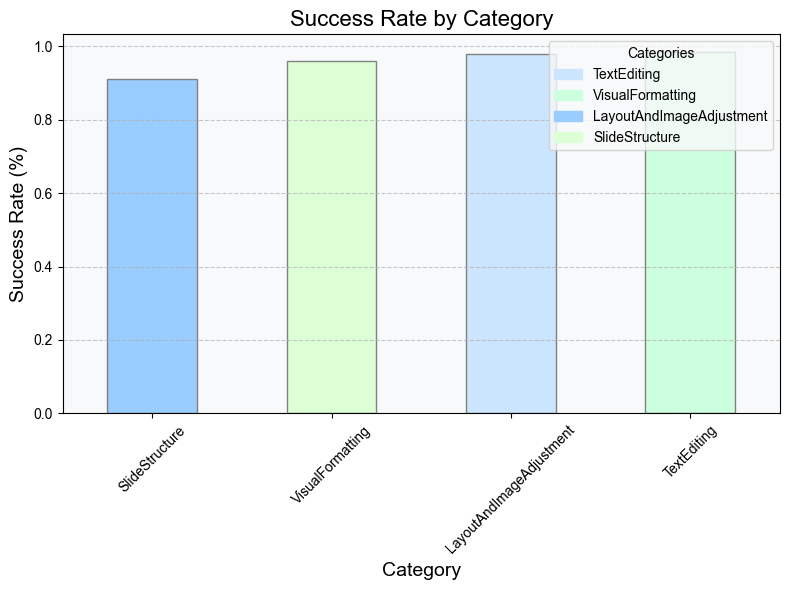

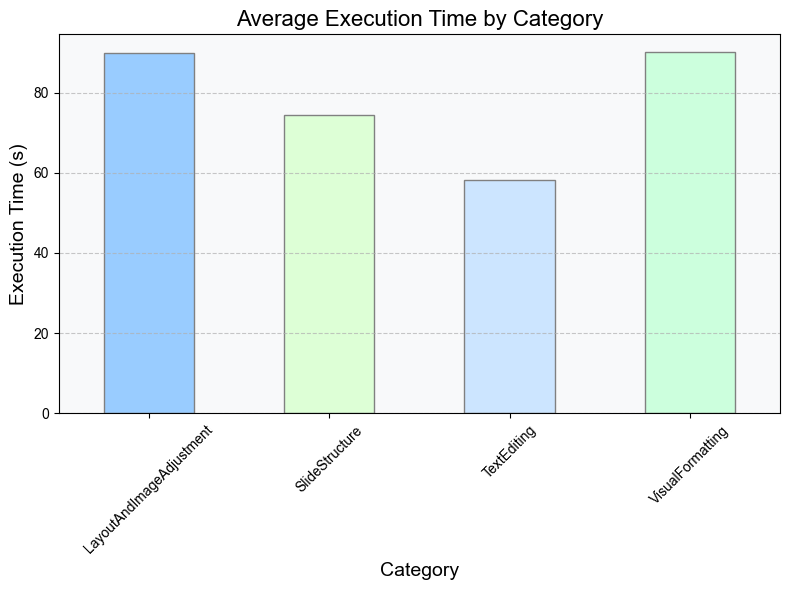

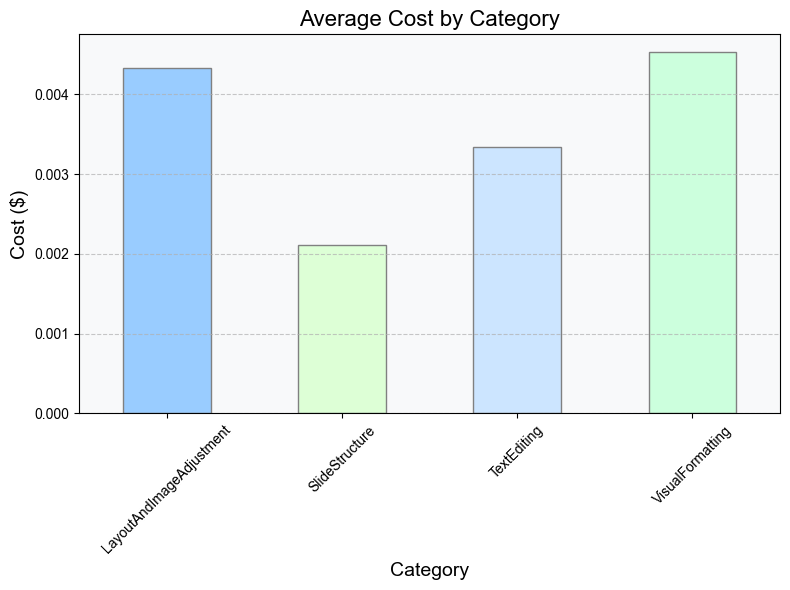

C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_21852\2937387902.py:227: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.boxplot(
C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_21852\2937387902.py:227: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.boxplot(
C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_21852\2937387902.py:227: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.boxplot(
C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_21852\2937387902.py:227: FutureWarning: 

Passing `palette` without assigning `hue` is depre

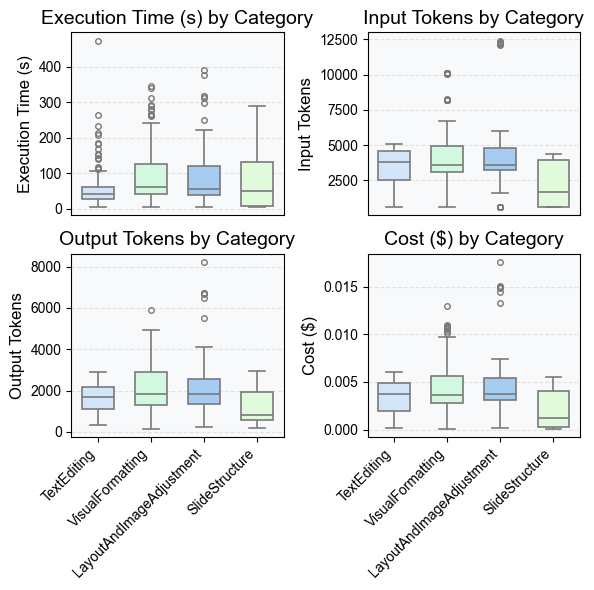


📝 카테고리별 상세 통계 요약


,Category,Total Count,Success Count,Success Rate (%),Avg Execution Time (s),Avg Input Tokens,Avg Output Tokens,Avg Cost ($),Total Cost ($)
0,TextEditing,116,114,98.28,58.715,3357.99,1662.59,0.0033,0.3814
2,LayoutAndImageAdjustment,95,93,97.89,88.775,3991.52,2095.42,0.0043,0.4033
1,VisualFormatting,123,118,95.93,93.530,4246.50,2156.84,0.0045,0.5340
3,SlideStructure,45,41,91.11,77.589,2243.17,1284.02,0.0021,0.0865


In [10]:
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import display

# 셀 1: 라이브러리 임포트 및 시각화 설정
import seaborn as sns
from matplotlib.colors import LinearSegmentedColormap

plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.sans-serif'] = ['Helvetica', 'Arial']
plt.rcParams['figure.figsize'] = [10, 8]
# plt.style.use('seaborn-pastel')  # 오래된 스타일 이름으로 오류 발생

# 파스텔 색상 설정 (모든 그래프에 일관되게 적용)
pastel_colors = {
    'TextEditing': '#CCE5FF',        # 연한 하늘색
    'VisualFormatting': '#CCFFDD',   # 연한 민트색
    'LayoutAndImageAdjustment': '#99CCFF',  # 밝은 파랑색
    'SlideStructure': '#DDFFD6'      # 연한 연두색
}

# 그래프 디자인 개선을 위한 설정
plt.rcParams['axes.facecolor'] = '#f8f9fa'
plt.rcParams['figure.facecolor'] = 'white'
plt.rcParams['grid.alpha'] = 0.3
plt.rcParams['grid.linestyle'] = '--'

# 셀 2: JSONL 파일 로드 함수 정의 및 데이터 프레임 생성
def load_jsonl(filepath):
    """JSONL 파일을 읽어 pandas.DataFrame 으로 반환"""
    records = []
    with open(filepath, 'r', encoding='utf-8') as f:
        for line in f:
            obj = json.loads(line)
            if 'instruction_key' in obj:
                records.append(obj)
    return pd.DataFrame(records)

# instruction_key에 대한 카테고리 매핑 정의
category_map = {
  "0": "TextEditing", "1": "TextEditing", "2": "TextEditing", 
  "3": "TextEditing", "4": "TextEditing", "5": "TextEditing",
  "6": "TextEditing", "7": "TextEditing", "8": "TextEditing",
  "9": "TextEditing", "10": "TextEditing", "11": "VisualFormatting",
  "12": "VisualFormatting", "13": "TextEditing", "14": "VisualFormatting",
  "15": "TextEditing", "16": "VisualFormatting", "17": "LayoutAndImageAdjustment",
  "18": "VisualFormatting", "19": "TextEditing", "20": "VisualFormatting",
  "21": "VisualFormatting", "22": "VisualFormatting", "23": "VisualFormatting",
  "24": "VisualFormatting", "25": "VisualFormatting", "26": "VisualFormatting",
  "27": "VisualFormatting", "28": "VisualFormatting", "29": "LayoutAndImageAdjustment",
  "30": "LayoutAndImageAdjustment", "31": "LayoutAndImageAdjustment", "32": "LayoutAndImageAdjustment",
  "33": "LayoutAndImageAdjustment", "34": "LayoutAndImageAdjustment", "35": "LayoutAndImageAdjustment",
  "36": "LayoutAndImageAdjustment", "37": "LayoutAndImageAdjustment", "38": "LayoutAndImageAdjustment",
  "39": "LayoutAndImageAdjustment", "40": "VisualFormatting", "41": "VisualFormatting",
  "42": "VisualFormatting", "43": "LayoutAndImageAdjustment", "44": "LayoutAndImageAdjustment",
  "45": "VisualFormatting", "46": "SlideStructure", "47": "SlideStructure",
  "48": "SlideStructure", "49": "LayoutAndImageAdjustment", "50": "SlideStructure",
  "51": "SlideStructure", "52": "SlideStructure", "53": "VisualFormatting",
  "54": "TextEditing", "55": "TextEditing"
}

# 셀 3: 데이터 로드 및 전처리
df = load_jsonl("result_gpt4-1/experiment_log.jsonl")

# instruction_key에서 카테고리 추출 (2-2와 같이 하이픈이 있는 경우 첫 번째 숫자만 사용)
def get_category(key):
    # 하이픈이 있으면 첫 부분만 추출
    base_key = key.split('-')[0] if '-' in key else key
    return category_map.get(base_key, "Unknown")

# 카테고리 컬럼 추가
df['category'] = df['instruction_key'].apply(get_category)

# 'result' 컬럼 분해 및 성공 플래그 생성
df['success_flag'] = df['status'] == 'success'

# 안전하게 result 리스트에서 토큰·비용 분리
df['input_tokens'] = df['result'].apply(
    lambda r: r[1] if isinstance(r, list) and len(r) > 1 else np.nan
)
df['output_tokens'] = df['result'].apply(
    lambda r: r[2] if isinstance(r, list) and len(r) > 2 else np.nan
)
df['cost'] = df['result'].apply(
    lambda r: r[3] if isinstance(r, list) and len(r) > 3 else np.nan
)

# 셀 4: 전체 통계 계산 및 출력
print("📊 전체 데이터 통계\n" + "="*50)

# 1) 실행 성공율
success_rate = df['success_flag'].mean()

# 2) execution_time 통계
exec_mean = df['execution_time'].mean()
exec_var  = df['execution_time'].var()
exec_sum  = df['execution_time'].sum()

# 3) 토큰·비용 통계
stats = {}
for col in ['input_tokens','output_tokens','cost']:
    stats[col] = {
        'mean': df[col].mean(),
        'var' : df[col].var(),
        'sum' : df[col].sum()
    }

# 4) 전체 요약 통계
summary = df[['execution_time','input_tokens','output_tokens','cost']].describe()

# 5) 상태별 건수
counts_by_status = df['status'].value_counts()

# 결과 출력
print(f"✅ 실행 성공율: {success_rate*100:.2f}%\n")

print("⏱ execution_time")
print(f"  평균: {exec_mean:.3f}s, 분산: {exec_var:.3f}, 합계: {exec_sum:.3f}s\n")

for col, v in stats.items():
    print(f"📊 {col}")
    print(f"  평균: {v['mean']:.2f}, 분산: {v['var']:.2f}, 합계: {v['sum']:.2f}\n")

print("🔢 상태별 건수")
display(counts_by_status)

print("\n📝 전체 요약 통계")
display(summary)

# 셀 5: 카테고리별 통계 계산
print("\n\n📊 카테고리별 통계\n" + "="*50)

# 카테고리별 데이터 수
category_counts = df['category'].value_counts()
print("\n🔢 카테고리별 데이터 건수")
display(category_counts)

# 카테고리별 성공률
category_success = df.groupby('category')['success_flag'].mean()
print("\n✅ 카테고리별 성공률")
display(category_success * 100)

# 카테고리별 평균 통계
category_stats = df.groupby('category')[['execution_time', 'input_tokens', 'output_tokens', 'cost']].mean()
print("\n📊 카테고리별 평균값")
display(category_stats)

# 카테고리별 합계 통계
category_sums = df.groupby('category')[['execution_time', 'input_tokens', 'output_tokens', 'cost']].sum()
print("\n📊 카테고리별 합계")
display(category_sums)

# 셀 6: 카테고리별 시각화 (파스텔 색상으로 통일)

# 카테고리별 성공률 시각화
plt.figure(figsize=(8, 6))
ax = category_success.sort_values().plot(
    kind='bar', 
    color=[pastel_colors[cat] for cat in category_success.index],
    edgecolor='gray'
)
plt.title('Success Rate by Category', fontsize=16)
plt.xlabel('Category', fontsize=14)
plt.ylabel('Success Rate (%)', fontsize=14)
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)

# 범례 추가
handles = [plt.Rectangle((0,0),1,1, color=pastel_colors[cat]) for cat in pastel_colors.keys()]
plt.legend(handles, pastel_colors.keys(), title="Categories")

plt.tight_layout()
plt.show()

# 카테고리별 평균 실행 시간 시각화
plt.figure(figsize=(8, 6))
ax = category_stats['execution_time'].plot(
    kind='bar', 
    color=[pastel_colors[cat] for cat in category_stats.index],
    edgecolor='gray'
)
plt.title('Average Execution Time by Category', fontsize=16)
plt.xlabel('Category', fontsize=14)
plt.ylabel('Execution Time (s)', fontsize=14)
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

# 카테고리별 평균 비용 시각화
plt.figure(figsize=(8, 6))
ax = category_stats['cost'].plot(
    kind='bar', 
    color=[pastel_colors[cat] for cat in category_stats.index],
    edgecolor='gray'
)
plt.title('Average Cost by Category', fontsize=16)
plt.xlabel('Category', fontsize=14)
plt.ylabel('Cost ($)', fontsize=14)
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

# 셀 7: 카테고리별 박스플롯 비교 (파스텔 색상 적용)
# 주요 메트릭에 대한 카테고리별 박스플롯
metrics = ['execution_time', 'input_tokens', 'output_tokens', 'cost']
titles = {
    'execution_time': 'Execution Time (s)',
    'input_tokens': 'Input Tokens',
    'output_tokens': 'Output Tokens',
    'cost': 'Cost ($)'
}

# 커스텀 파스텔 팔레트를 seaborn에 전달할 형태로 변환
custom_palette = list(pastel_colors.values())

plt.figure(figsize=(6, 6))
for i, metric in enumerate(metrics, 1):
    plt.subplot(2, 2, i)
    # 성공한 케이스만 선택
    success_df = df[df['success_flag']]
    
    # 파스텔 컬러 적용
    ax = sns.boxplot(
        x='category', 
        y=metric, 
        data=success_df, 
        palette=custom_palette,
        width=0.6,
        linewidth=1.2,
        fliersize=4
    )
    
    plt.title(f'{titles[metric]} by Category', fontsize=14)
    plt.xlabel('', fontsize=12)  # x축 레이블 숨김 (공간 절약)
    plt.ylabel(titles[metric], fontsize=12)
    plt.grid(axis='y', linestyle='--', alpha=0.3)
    
    # x축 레이블 가독성 향상
    if i > 2:  # 하단 subplot에만 카테고리 레이블 표시
        plt.xticks(rotation=45, ha='right')
    else:
        plt.xticks([])  # 상단 subplot에서는 x축 레이블 숨김
        
    # 배경에 약간의 그리드 추가
    ax.set_axisbelow(True)
    
plt.tight_layout()
plt.show()

# 셀 8: 상세 카테고리별 통계 테이블 생성
# 카테고리별 상세 통계 데이터프레임 생성
detailed_stats = []

for category in df['category'].unique():
    cat_df = df[df['category'] == category]
    cat_success = cat_df['success_flag'].mean()
    
    # 성공한 케이스만 선택하여 통계 계산
    cat_success_df = cat_df[cat_df['success_flag']]
    
    # 기본 통계 추출
    stat = {
        'Category': category,
        'Total Count': len(cat_df),
        'Success Count': len(cat_success_df),
        'Success Rate (%)': cat_success * 100,
        'Avg Execution Time (s)': cat_success_df['execution_time'].mean(),
        'Avg Input Tokens': cat_success_df['input_tokens'].mean(),
        'Avg Output Tokens': cat_success_df['output_tokens'].mean(),
        'Avg Cost ($)': cat_success_df['cost'].mean(),
        'Total Cost ($)': cat_success_df['cost'].sum()
    }
    detailed_stats.append(stat)

# 데이터프레임으로 변환하고 성공률 기준으로 정렬
detailed_df = pd.DataFrame(detailed_stats).sort_values('Success Rate (%)', ascending=False)

# 소수점 포맷팅
format_dict = {
    'Success Rate (%)': '{:.2f}',
    'Avg Execution Time (s)': '{:.3f}',
    'Avg Input Tokens': '{:.2f}',
    'Avg Output Tokens': '{:.2f}',
    'Avg Cost ($)': '{:.4f}',
    'Total Cost ($)': '{:.4f}'
}

# 포맷팅 적용
for col, fmt in format_dict.items():
    detailed_df[col] = detailed_df[col].apply(lambda x: fmt.format(x))

print("\n📝 카테고리별 상세 통계 요약")
display(detailed_df)

In [ ]:
%pip install seaborn

In [ ]:
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display

# 파스텔 색상 설정 (모든 그래프에 일관되게 적용)
pastel_colors = {
    'TextEditing': '#CCE5FF',        # 연한 하늘색
    'VisualFormatting': '#CCFFDD',   # 연한 민트색
    'LayoutAndImageAdjustment': '#99CCFF',  # 밝은 파랑색
    'SlideStructure': '#DDFFD6'      # 연한 연두색
}

# 그래프 디자인 개선을 위한 설정
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.sans-serif'] = ['Helvetica', 'Arial']
plt.rcParams['figure.figsize'] = [10, 8]
plt.rcParams['axes.facecolor'] = '#f8f9fa'
plt.rcParams['figure.facecolor'] = 'white'
plt.rcParams['grid.alpha'] = 0.3
plt.rcParams['grid.linestyle'] = '--'

# JSONL 파일 로드 함수 정의 및 데이터 프레임 생성
def load_jsonl(filepath):
    """JSONL 파일을 읽어 pandas.DataFrame 으로 반환"""
    records = []
    with open(filepath, 'r', encoding='utf-8') as f:
        for line in f:
            obj = json.loads(line)
            if 'instruction_key' in obj:
                records.append(obj)
    return pd.DataFrame(records)

# instruction_key에 대한 카테고리 매핑 정의
category_map = {
  "0": "TextEditing", "1": "TextEditing", "2": "TextEditing", 
  "3": "TextEditing", "4": "TextEditing", "5": "TextEditing",
  "6": "TextEditing", "7": "TextEditing", "8": "TextEditing",
  "9": "TextEditing", "10": "TextEditing", "11": "VisualFormatting",
  "12": "VisualFormatting", "13": "TextEditing", "14": "VisualFormatting",
  "15": "TextEditing", "16": "VisualFormatting", "17": "LayoutAndImageAdjustment",
  "18": "VisualFormatting", "19": "TextEditing", "20": "VisualFormatting",
  "21": "VisualFormatting", "22": "VisualFormatting", "23": "VisualFormatting",
  "24": "VisualFormatting", "25": "VisualFormatting", "26": "VisualFormatting",
  "27": "VisualFormatting", "28": "VisualFormatting", "29": "LayoutAndImageAdjustment",
  "30": "LayoutAndImageAdjustment", "31": "LayoutAndImageAdjustment", "32": "LayoutAndImageAdjustment",
  "33": "LayoutAndImageAdjustment", "34": "LayoutAndImageAdjustment", "35": "LayoutAndImageAdjustment",
  "36": "LayoutAndImageAdjustment", "37": "LayoutAndImageAdjustment", "38": "LayoutAndImageAdjustment",
  "39": "LayoutAndImageAdjustment", "40": "VisualFormatting", "41": "VisualFormatting",
  "42": "VisualFormatting", "43": "LayoutAndImageAdjustment", "44": "LayoutAndImageAdjustment",
  "45": "VisualFormatting", "46": "SlideStructure", "47": "SlideStructure",
  "48": "SlideStructure", "49": "LayoutAndImageAdjustment", "50": "SlideStructure",
  "51": "SlideStructure", "52": "SlideStructure", "53": "VisualFormatting",
  "54": "TextEditing", "55": "TextEditing"
}

# 데이터 로드 및 전처리
df = load_jsonl("result/experiment_log.jsonl")

# instruction_key에서 카테고리 추출 (2-2와 같이 하이픈이 있는 경우 첫 번째 숫자만 사용)
def get_category(key):
    # 하이픈이 있으면 첫 부분만 추출
    base_key = key.split('-')[0] if '-' in key else key
    return category_map.get(base_key, "Unknown")

# 카테고리 컬럼 추가
df['category'] = df['instruction_key'].apply(get_category)

# 'result' 컬럼 분해 및 성공 플래그 생성
df['success_flag'] = df['status'] == 'success'

# 안전하게 result 리스트에서 토큰·비용 분리
df['input_tokens'] = df['result'].apply(
    lambda r: r[1] if isinstance(r, list) and len(r) > 1 else np.nan
)
df['output_tokens'] = df['result'].apply(
    lambda r: r[2] if isinstance(r, list) and len(r) > 2 else np.nan
)
df['cost'] = df['result'].apply(
    lambda r: r[3] if isinstance(r, list) and len(r) > 3 else np.nan
)

# 성공한 케이스만 선택
success_df = df[df['success_flag']]

# 이상치 제거 함수 정의
def remove_outliers(df, category, column, method='iqr', threshold=3.0):
    """
    특정 카테고리내의 열에서 이상치를 제거하는 함수
    
    Parameters:
    -----------
    df : DataFrame
        대상 데이터프레임
    category : str
        이상치를 제거할 카테고리명
    column : str
        이상치를 제거할 열 이름
    method : str, 옵션 ('iqr' 또는 'zscore')
        이상치 탐지 방법
    threshold : float
        이상치 판별 임계값 (IQR 방식에서는 배수, Z-score 방식에서는 표준편차)
        
    Returns:
    --------
    DataFrame
        이상치가 제거된 데이터프레임
    """
    # 카테고리에 해당하는 데이터만 필터링
    cat_df = df[df['category'] == category].copy()
    
    if method == 'iqr':
        # IQR 방식 (사분위수 범위의 배수를 사용)
        Q1 = cat_df[column].quantile(0.25)
        Q3 = cat_df[column].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - threshold * IQR
        upper_bound = Q3 + threshold * IQR
        
        # 이상치 식별
        outliers = (cat_df[column] < lower_bound) | (cat_df[column] > upper_bound)
        
    elif method == 'zscore':
        # Z-score 방식 (평균으로부터 표준편차의 배수를 사용)
        mean = cat_df[column].mean()
        std = cat_df[column].std()
        z_scores = abs((cat_df[column] - mean) / std)
        outliers = z_scores > threshold
    
    else:
        raise ValueError(f"지원되지 않는 방법: {method}")
    
    # 이상치 정보 출력
    if outliers.any():
        print(f"⚠️ '{category}' 카테고리의 '{column}' 열에서 {outliers.sum()}개의 이상치 발견됨")
        print(f"  - 이상치 값: {cat_df.loc[outliers, column].values}")
    
    # 원본 데이터프레임에서 해당 카테고리의 이상치 제거
    result_df = df.copy()
    cat_indices = result_df[result_df['category'] == category].index
    outlier_indices = cat_df.loc[outliers].index
    
    # 이상치 제거된 데이터프레임 반환
    return result_df[~result_df.index.isin(outlier_indices)]

# 'VisualFormatting' 카테고리에서 'output_tokens'와 'cost'의 이상치 제거
# IQR 방식 사용, 이상치 기준은 IQR의 3배로 설정
print("\n🔍 이상치 탐지 및 제거")
print("="*50)

# 이상치 제거 전 통계 확인
print("\n▶️ 이상치 제거 전 카테고리별 output_tokens 통계:")
vf_before = success_df[success_df['category'] == 'VisualFormatting']['output_tokens']
print(f"VisualFormatting output_tokens 최대값: {vf_before.max()}")
print(f"VisualFormatting output_tokens 평균값: {vf_before.mean()}")

# 데이터 복사 - outlier를 제거한 새로운 데이터프레임 생성
filtered_df = remove_outliers(success_df, 'VisualFormatting', 'output_tokens', method='iqr', threshold=1.5)

# 필터링된 데이터로 비용 이상치도 제거 (통상 토큰과 비용은 상관관계가 높음)
# 별도 필터링이 필요하면 아래 주석 해제
# filtered_df = remove_outliers(filtered_df, 'VisualFormatting', 'cost', method='iqr', threshold=1.5)

# 이상치 제거 후 통계 확인
print("\n▶️ 이상치 제거 후 카테고리별 output_tokens 통계:")
vf_after = filtered_df[filtered_df['category'] == 'VisualFormatting']['output_tokens']
print(f"VisualFormatting output_tokens 최대값: {vf_after.max()}")
print(f"VisualFormatting output_tokens 평균값: {vf_after.mean()}")

# 카테고리별 통계 다시 계산 (이상치 제거 후)
category_stats_filtered = filtered_df.groupby('category')[['execution_time', 'input_tokens', 'output_tokens', 'cost']].mean()

print("\n📊 이상치 제거 후 카테고리별 평균값")
display(category_stats_filtered)

# ---------------------- 이상치 제거 후 시각화 -----------------------
print("\n📈 이상치 제거 후 시각화")
print("="*50)

# 1. 카테고리별 평균 출력 토큰 시각화 (이상치 제거 후)
plt.figure(figsize=(10, 6))
ax = category_stats_filtered['output_tokens'].plot(
    kind='bar', 
    color=[pastel_colors[cat] for cat in category_stats_filtered.index],
    edgecolor='gray'
)
plt.title('Average Output Tokens by Category (Outliers Removed)', fontsize=16)
plt.xlabel('Category', fontsize=14)
plt.ylabel('Output Tokens', fontsize=14)
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)

# 범례 추가
handles = [plt.Rectangle((0,0),1,1, color=pastel_colors[cat]) for cat in pastel_colors.keys()]
plt.legend(handles, pastel_colors.keys(), title="Categories")

plt.tight_layout()
plt.show()

# 2. 카테고리별 평균 비용 시각화 (이상치 제거 후)
plt.figure(figsize=(10, 6))
ax = category_stats_filtered['cost'].plot(
    kind='bar', 
    color=[pastel_colors[cat] for cat in category_stats_filtered.index],
    edgecolor='gray'
)
plt.title('Average Cost by Category (Outliers Removed)', fontsize=16)
plt.xlabel('Category', fontsize=14)
plt.ylabel('Cost ($)', fontsize=14)
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

# 3. 업데이트된 카테고리별 박스플롯 비교 (이상치 제거 후)
metrics = ['execution_time', 'input_tokens', 'output_tokens', 'cost']
titles = {
    'execution_time': 'Execution Time (s)',
    'input_tokens': 'Input Tokens',
    'output_tokens': 'Output Tokens (Outliers Removed)',
    'cost': 'Cost ($) (Outliers Removed)'
}

# 커스텀 파스텔 팔레트를 seaborn에 전달할 형태로 변환
custom_palette = list(pastel_colors.values())

plt.figure(figsize=(6, 5))
for i, metric in enumerate(metrics, 1):
    plt.subplot(2, 2, i)
    
    # 파스텔 컬러 적용, showfliers=False로 박스플롯의 이상치 표시 제거
    # whis 매개변수를 낮게 설정해 더 엄격하게 이상치 판별 (기본값은 1.5)
    ax = sns.boxplot(
        x='category', 
        y=metric, 
        data=filtered_df, 
        palette=custom_palette,
        width=0.6,
        linewidth=1.2,
        showfliers=(metric not in ['output_tokens', 'cost']),  # output_tokens와 cost에서는 이상치 표시 제거
        whis=1.5
    )
    
    plt.title(f'{titles[metric]}', fontsize=14)
    plt.xlabel('', fontsize=12)  # x축 레이블 숨김 (공간 절약)
    plt.ylabel(titles[metric], fontsize=12)
    plt.grid(axis='y', linestyle='--', alpha=0.3)
    
    # x축 레이블 가독성 향상
    if i > 2:  # 하단 subplot에만 카테고리 레이블 표시
        plt.xticks(rotation=45, ha='right')
    else:
        plt.xticks([])  # 상단 subplot에서는 x축 레이블 숨김
        
    # 배경에 약간의 그리드 추가
    ax.set_axisbelow(True)
    
plt.tight_layout()
plt.show()

# 4. 이상치 분포 시각화 (VisualFormatting 카테고리)
# 원본 데이터의 VisualFormatting 카테고리 출력 토큰 분포
plt.figure(figsize=(12, 6))

# 첫 번째 서브플롯: VisualFormatting 카테고리의 출력 토큰 분포 (이상치 포함)
plt.subplot(1, 2, 1)
vf_data = success_df[success_df['category'] == 'VisualFormatting']['output_tokens']
plt.hist(vf_data, bins=20, color=pastel_colors['VisualFormatting'], edgecolor='gray')
plt.title('Output Tokens in VisualFormatting\n(with outliers)', fontsize=14)
plt.xlabel('Output Tokens', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.3)

# 두 번째 서브플롯: VisualFormatting 카테고리의 출력 토큰 분포 (이상치 제거 후)
plt.subplot(1, 2, 2)
vf_filtered = filtered_df[filtered_df['category'] == 'VisualFormatting']['output_tokens']
plt.hist(vf_filtered, bins=20, color=pastel_colors['VisualFormatting'], edgecolor='gray')
plt.title('Output Tokens in VisualFormatting\n(outliers removed)', fontsize=14)
plt.xlabel('Output Tokens', fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.3)

plt.tight_layout()
plt.show()

# 5. 이상치를 확인하기 위한 스캐터 플롯 (출력 토큰 vs 비용)
plt.figure(figsize=(10, 6))
colors = [pastel_colors.get(cat, '#CCCCCC') for cat in success_df['category']]

plt.scatter(
    success_df['output_tokens'], 
    success_df['cost'],
    c=colors,
    alpha=0.7,
    edgecolor='gray'
)

# 제거된 이상치 강조 표시
outlier_indices = set(success_df.index) - set(filtered_df.index)
outliers = success_df.loc[list(outlier_indices)]  # 집합(set)을 리스트로 변환
if not outliers.empty:
    plt.scatter(
        outliers['output_tokens'],
        outliers['cost'],
        c='red',
        s=100,
        marker='x',
        label='Removed Outliers'
    )

plt.title('Output Tokens vs Cost (Outliers Highlighted)', fontsize=16)
plt.xlabel('Output Tokens', fontsize=14)
plt.ylabel('Cost ($)', fontsize=14)
plt.grid(linestyle='--', alpha=0.3)

# 범례 추가
handles = [plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=color, markersize=10) 
           for color in pastel_colors.values()]
labels = pastel_colors.keys()
plt.legend(handles + [plt.Line2D([0], [0], marker='x', color='red', markersize=10, linestyle='None')], 
           list(labels) + ['Outliers'], title="Categories")

plt.tight_layout()
plt.show()

# GPT Judge 준비

## slide image 추출

In [2]:
import os
from win32com import client

def export_slide_images(ppt_path, out_dir, width=1024, height=576):
    """
    Exports each slide of the given PPTX to a PNG image.
    Uses absolute paths so that PowerPoint COM can find the output folder.
    """
    ppt_app = client.Dispatch("PowerPoint.Application")
    # Open(FileName, ReadOnly, Untitled, WithWindow)
    presentation = ppt_app.Presentations.Open(
        os.path.abspath(ppt_path),
        False,   # ReadOnly
        True,    # Untitled
        False    # WithWindow
    )

    abs_out_dir = os.path.abspath(out_dir)
    os.makedirs(abs_out_dir, exist_ok=True)

    # Get slide count before exporting
    slide_count = presentation.Slides.Count
    
    for idx, slide in enumerate(presentation.Slides, start=1):
        image_path = os.path.join(abs_out_dir, f"slide_{idx:02}.png")
        # slide.Export(FileName, FilterName, ScaleWidth, ScaleHeight)
        slide.Export(image_path, "PNG", width, height)

    presentation.Close()
    ppt_app.Quit()
    
    print(f"  Exported {slide_count} slides")

if __name__ == "__main__":
    result_dir = "result_ufo_evaluation"
    images_root = os.path.join(result_dir, "images")
    
    # 결과 디렉터리가 없으면 생성
    os.makedirs(images_root, exist_ok=True)

    # 이미 처리된 프레젠테이션 목록
    processed_ppts = []
    
    # 이미 이미지가 생성된 프레젠테이션 확인
    if os.path.exists(images_root):
        for folder in os.listdir(images_root):
            folder_path = os.path.join(images_root, folder)
            if os.path.isdir(folder_path) and any(os.listdir(folder_path)):
                processed_ppts.append(folder)
                print(f"[INFO] Skipping {folder}.pptx (already processed)")

    # result 디렉터리 내 모든 .pptx 파일에 대해
    total_ppts = 0
    processed = 0
    skipped = 0
    
    for fname in os.listdir(result_dir):
        if not fname.lower().endswith(".pptx"):
            continue
            
        total_ppts += 1
        base_name = os.path.splitext(fname)[0]
        
        # 이미 처리된 프레젠테이션은 건너뜀
        if base_name in processed_ppts:
            skipped += 1
            continue
        
        ppt_path = os.path.join(result_dir, fname)
        out_dir = os.path.join(images_root, base_name)

        print(f"[INFO] Exporting slides from {ppt_path} → {out_dir}")
        export_slide_images(ppt_path, out_dir)
        processed += 1

    print(f"Done! Processed {processed} presentations, skipped {skipped} existing presentations (total: {total_ppts})")

[INFO] Exporting slides from result_ufo_evaluation\result_slide_0_instruction_0-0.pptx → result_ufo_evaluation\images\result_slide_0_instruction_0-0
  Exported 1 slides
[INFO] Exporting slides from result_ufo_evaluation\result_slide_0_instruction_0-1.pptx → result_ufo_evaluation\images\result_slide_0_instruction_0-1
  Exported 1 slides
[INFO] Exporting slides from result_ufo_evaluation\result_slide_0_instruction_0-2.pptx → result_ufo_evaluation\images\result_slide_0_instruction_0-2
  Exported 1 slides
[INFO] Exporting slides from result_ufo_evaluation\result_slide_0_instruction_0-3.pptx → result_ufo_evaluation\images\result_slide_0_instruction_0-3
  Exported 1 slides
[INFO] Exporting slides from result_ufo_evaluation\result_slide_0_instruction_0-4.pptx → result_ufo_evaluation\images\result_slide_0_instruction_0-4
  Exported 1 slides
[INFO] Exporting slides from result_ufo_evaluation\result_slide_0_instruction_0-5.pptx → result_ufo_evaluation\images\result_slide_0_instruction_0-5
  Expo

# slide note 추출

In [1]:
import os
import win32com.client
import time
import comtypes.client
import pythoncom

def extract_slide_notes(ppt_path, out_dir):
    """
    Extracts notes from each slide in a PPTX using win32com.
    This requires Microsoft PowerPoint to be installed.
    """
    # 절대 경로로 변환
    ppt_path = os.path.abspath(ppt_path)
    out_dir = os.path.abspath(out_dir)
    os.makedirs(out_dir, exist_ok=True)
    
    # COM 스레드를 초기화
    pythoncom.CoInitialize()
    
    try:
        # PowerPoint 애플리케이션 객체 생성
        app = win32com.client.Dispatch("PowerPoint.Application")
        # PowerPoint 파일 열기 (창을 숨기는 옵션 사용하지 않음)
        presentation = app.Presentations.Open(ppt_path, ReadOnly=True, WithWindow=True)
        
        # 각 슬라이드 처리
        slide_count = presentation.Slides.Count
        for idx in range(1, slide_count + 1):
            slide = presentation.Slides.Item(idx)
            notes_text = ""
            
            try:
                # 노트 페이지에서 텍스트 추출
                if hasattr(slide, "NotesPage"):
                    notes_page = slide.NotesPage
                    
                    # 모든 Shape 확인
                    for shape_idx in range(1, notes_page.Shapes.Count + 1):
                        shape = notes_page.Shapes.Item(shape_idx)
                        if hasattr(shape, "TextFrame"):
                            if shape.TextFrame.HasText:
                                notes_text += shape.TextFrame.TextRange.Text + "\n"
            
            except Exception as e:
                print(f"[WARNING] Error extracting notes from slide {idx}: {str(e)}")
            
            # 노트를 파일로 저장
            note_file = os.path.join(out_dir, f"slide_{idx:02}.txt")
            with open(note_file, "w", encoding="utf-8") as f:
                f.write(notes_text)
        
        # 프레젠테이션 닫기 (저장하지 않음)
        presentation.Close()
        
    except Exception as e:
        raise e
    finally:
        # PowerPoint 종료 시도
        try:
            app.Quit()
        except:
            pass
        # COM 객체 참조 해제
        del app
        # COM 스레드 정리
        pythoncom.CoUninitialize()

def extract_slide_notes_using_comtypes(ppt_path, out_dir):
    """
    Alternative method using comtypes instead of win32com
    """
    import comtypes.client
    
    # 절대 경로로 변환
    ppt_path = os.path.abspath(ppt_path)
    out_dir = os.path.abspath(out_dir)
    os.makedirs(out_dir, exist_ok=True)
    
    # PowerPoint 상수
    ppSaveAsText = 4  # Text file format
    
    # PowerPoint 애플리케이션 생성
    ppt = comtypes.client.CreateObject("PowerPoint.Application")
    
    try:
        # 프레젠테이션 열기
        presentation = ppt.Presentations.Open(ppt_path, WithWindow=False)
        
        # 슬라이드 수
        slide_count = presentation.Slides.Count
        
        # 각 슬라이드의 노트 내용 저장
        for i in range(1, slide_count + 1):
            try:
                slide = presentation.Slides.Item(i)
                note_text = ""
                
                # 노트 텍스트 추출
                if hasattr(slide, "NotesPage"):
                    notes_page = slide.NotesPage
                    for shape_idx in range(1, notes_page.Shapes.Count + 1):
                        shape = notes_page.Shapes.Item(shape_idx)
                        if hasattr(shape, "TextFrame"):
                            if shape.TextFrame.HasText:
                                note_text += shape.TextFrame.TextRange.Text + "\n"
                
                # 노트 저장
                note_file = os.path.join(out_dir, f"slide_{i:02}.txt")
                with open(note_file, "w", encoding="utf-8") as f:
                    f.write(note_text)
                    
            except Exception as e:
                print(f"[WARNING] Error processing slide {i}: {str(e)}")
                
        # 프레젠테이션 닫기
        presentation.Close()
        
    except Exception as e:
        raise e
    finally:
        # PowerPoint 종료
        try:
            ppt.Quit()
        except:
            pass
        
        # 참조 해제
        del ppt

if __name__ == "__main__":
    result_dir = "result_ufo_evaluation"
    notes_root = os.path.join(result_dir, "notes")
    os.makedirs(notes_root, exist_ok=True)
    
    # 사용할 방법 (win32com 또는 comtypes)
    use_comtypes = True
    
    # result 디렉터리 내 모든 .pptx 파일에 대해 노트 추출
    for fname in os.listdir(result_dir):
        if not fname.lower().endswith(".pptx"):
            continue
        ppt_path = os.path.join(result_dir, fname)
        base_name = os.path.splitext(fname)[0]
        out_dir = os.path.join(notes_root, base_name)
        print(f"[INFO] Extracting notes from {ppt_path} → {out_dir}")
        
        try:
            if use_comtypes:
                extract_slide_notes_using_comtypes(ppt_path, out_dir)
            else:
                extract_slide_notes(ppt_path, out_dir)
                
            # 잠시 대기 (PowerPoint 객체가 확실히 해제되도록)
            time.sleep(1)
        except Exception as e:
            print(f"[ERROR] Failed to extract notes from {ppt_path}: {str(e)}")
    
    print("Done extracting all slide notes.")

[INFO] Extracting notes from result_ufo_evaluation\result_slide_0_instruction_0-0.pptx → result_ufo_evaluation\notes\result_slide_0_instruction_0-0
[INFO] Extracting notes from result_ufo_evaluation\result_slide_0_instruction_0-1.pptx → result_ufo_evaluation\notes\result_slide_0_instruction_0-1
[INFO] Extracting notes from result_ufo_evaluation\result_slide_0_instruction_0-2.pptx → result_ufo_evaluation\notes\result_slide_0_instruction_0-2
[INFO] Extracting notes from result_ufo_evaluation\result_slide_0_instruction_0-3.pptx → result_ufo_evaluation\notes\result_slide_0_instruction_0-3
[INFO] Extracting notes from result_ufo_evaluation\result_slide_0_instruction_0-4.pptx → result_ufo_evaluation\notes\result_slide_0_instruction_0-4
[INFO] Extracting notes from result_ufo_evaluation\result_slide_0_instruction_0-5.pptx → result_ufo_evaluation\notes\result_slide_0_instruction_0-5
[INFO] Extracting notes from result_ufo_evaluation\result_slide_0_instruction_0.pptx → result_ufo_evaluation\not